In [8]:
# Prepare paths to local utilities
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt

utils_path = os.path.abspath(os.path.join('..', 'util'))
sys.path.append(utils_path)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Import the data downloader from the local utilities package (stored in the ../util folder)
from download.DataDownloader import DataDownloader

In [10]:
data_path = os.path.abspath(os.path.join('..', 'data'))

In [11]:
# Prepare data downloader
data_downloader = DataDownloader()

In [12]:
# Download the two datasets
# har70+ and harth
har70plus_success = data_downloader.download_data('har70plus', data_path)

print("HAR70+ download success: ", har70plus_success)

harth_success = data_downloader.download_data('harth', data_path)

print("HARTH download success: ", harth_success)

if not har70plus_success or not harth_success:
    print("Data download failed, please check the logs above.")

Dataset already downloaded
HAR70+ download success:  True
Dataset already downloaded
HARTH download success:  True


In [13]:
# The HAR70+ dataset is a collection of many CSV files, load the first one as a test
har70plus_files = os.path.join(data_path, 'har70plus')

har70plus_files = [os.path.join(har70plus_files, f) for f in os.listdir(har70plus_files) if f.endswith('.csv')]

har70plus_1_df = pd.read_csv(har70plus_files[0])

har70plus_1_df.head()

timestamp    back_x    back_y    back_z   thigh_x   thigh_y  \
0  2021-03-24 14:42:03.839 -0.999023 -0.063477  0.140625 -0.980469 -0.112061   
1  2021-03-24 14:42:03.859 -0.980225 -0.079346  0.140625 -0.961182 -0.121582   
2  2021-03-24 14:42:03.880 -0.950195 -0.076416  0.140625 -0.949463 -0.080566   
3  2021-03-24 14:42:03.900 -0.954834 -0.059082  0.140381 -0.957520 -0.046143   
4  2021-03-24 14:42:03.920 -0.972412 -0.042969  0.142822 -0.977051 -0.023682   

    thigh_z  label  
0 -0.048096      6  
1 -0.051758      6  
2 -0.067139      6  
3 -0.050781      6  
4 -0.026611      6

In [36]:
# Each record has a timestamp, we need to check if the timestamps are evenly spaced.
# This is important for the time series analysis.

# The timestamp is stored in the format: yyyy-mm-dd hh:mm:ss.000 and is a string
# We can convert it to a datetime object and then calculate the difference between each pair of timestamps
# The difference should be constant if the timestamps are evenly spaced

# Convert the timestamp to a datetime object
har70plus_1_df['timestamp'] = pd.to_datetime(har70plus_1_df['timestamp'])

# Calculate the difference between each pair of timestamps
time_diff = har70plus_1_df['timestamp'].diff()

# The first difference is NaN, so let's fill it with 0 as the difference between the first and the first timestamp is 0
time_diff[0] = pd.Timedelta(0)

# Check if the difference is constant
time_diff.value_counts()

timestamp
0 days 00:00:00.020000    62797
0 days 00:00:00.019000    20528
0 days 00:00:00.021000    20524
0 days 00:00:00               1
0 days 00:00:01.180000        1
0 days 00:00:02.060000        1
0 days 00:00:03.180000        1
0 days 00:00:03.821000        1
0 days 00:00:03.021000        1
0 days 00:00:04.861000        1
0 days 00:00:01.541000        1
0 days 00:00:02.620000        1
0 days 00:00:01.020000        1
0 days 00:00:01.940000        1
Name: count, dtype: int64

In [37]:
# The difference is not constant, we need to check the distribution of the differences
time_diff.describe()

count                       103860
mean     0 days 00:00:00.020240901
std      0 days 00:00:00.027082560
min                0 days 00:00:00
25%         0 days 00:00:00.020000
50%         0 days 00:00:00.020000
75%         0 days 00:00:00.020000
max         0 days 00:00:04.861000
Name: timestamp, dtype: object

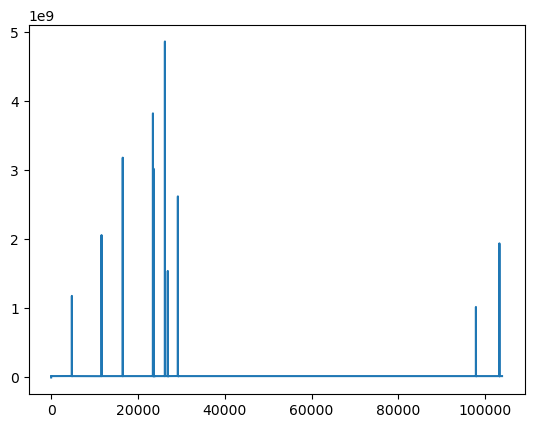

In [38]:
# There are occasional large differences, so let's check if this is due to missing timestamps, or if the timestamps are not evenly spaced
time_diff.plot()
plt.show()

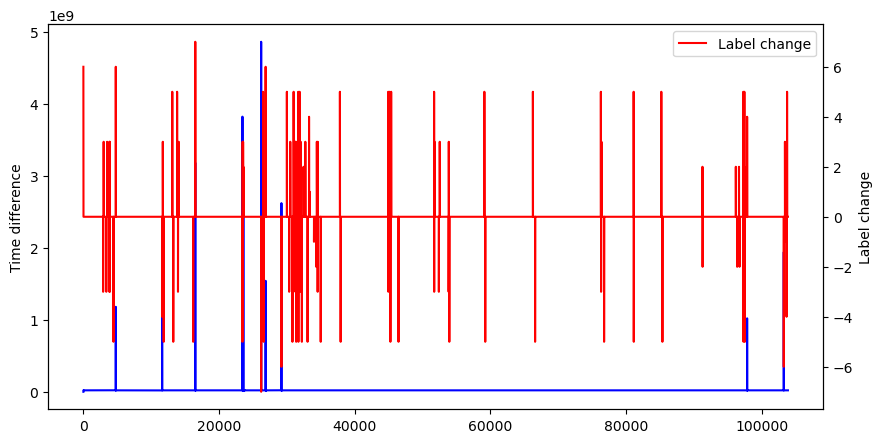

In [39]:
# Let's add to this graph the points where the label changes
# There are 6 labels in the dataset, we will plot them in different colors
label_changes = har70plus_1_df['label'].diff()

# The first label change is NaN, so we will fill it with the first label
label_changes[0] = har70plus_1_df['label'][0]

# Plot the time differences and the label changes
# The axis scales are different, so two y-axes are needed
plt.figure(figsize=(10, 5))

#
plt.plot(time_diff, 'b', label='Time difference')
plt.ylabel('Time difference')
plt.twinx()

plt.plot(label_changes, 'r', label='Label change')
plt.ylabel('Label change')
plt.legend()


plt.show()

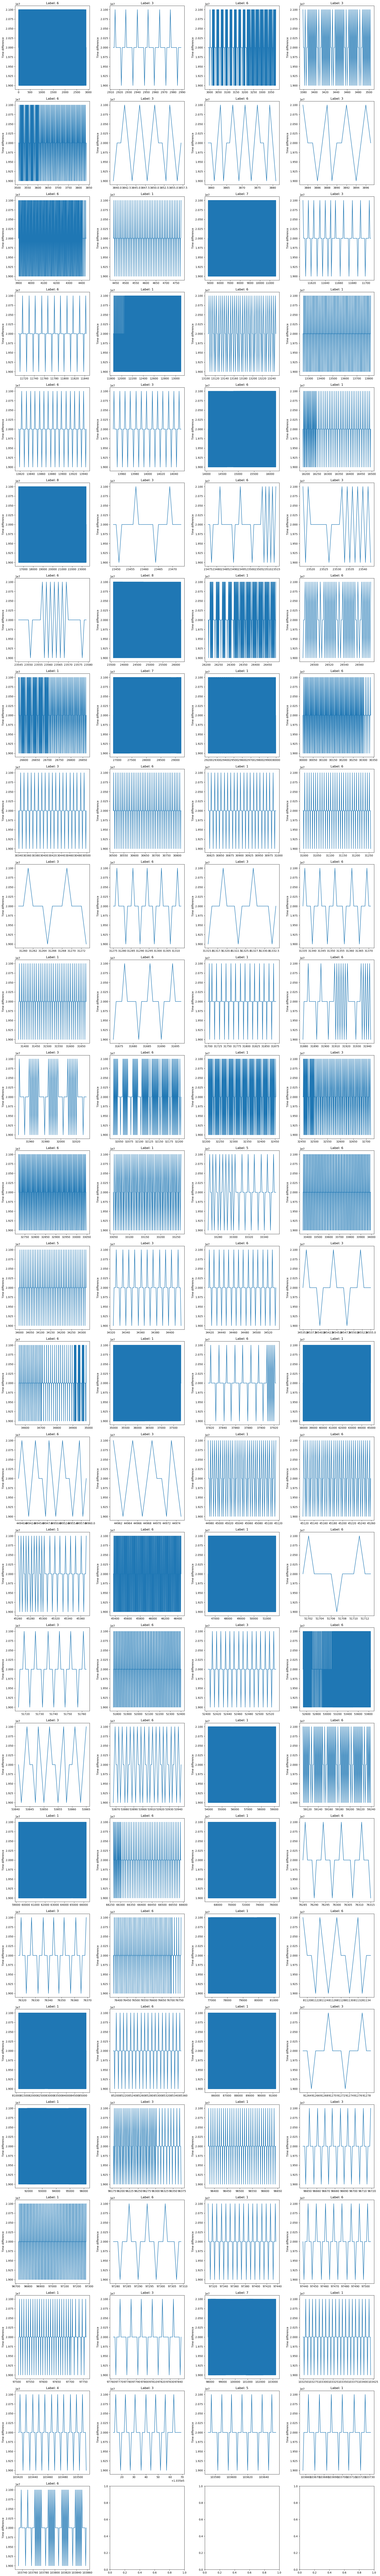

In [54]:
# The large time differences appear to line up with some of the label changes, but not every label change is associated with a large time difference
# This suggests that the timestamps are not evenly spaced, but the time differences are not due to missing timestamps

# Lets split the dataset by each change in the label and check the time differences in each subset
# We will plot the time differences for each subset

# Find the indices where the label changes
label_change_indices = har70plus_1_df.index[label_changes != 0]

# Add the last index to the list of changes
label_change_indices = label_change_indices.append(pd.Index([har70plus_1_df.index[-1]]))

# Split the dataset by the label changes
label_change_splits = [har70plus_1_df.iloc[label_change_indices[i]:label_change_indices[i+1]] for i in range(len(label_change_indices) - 1)]

# Plot each split on a separate graph in a grid
n_plots = len(label_change_splits)

num_per_row = 4
n_rows = n_plots // num_per_row + n_plots % num_per_row

fig, axs = plt.subplots(n_rows, num_per_row, figsize=(20, 5 * n_rows))

for i, split in enumerate(label_change_splits):
    split = split.copy()
    split['timestamp'] = pd.to_datetime(split['timestamp'])
    split_time_diff = split['timestamp'].diff()
    
    # Only plot the time differences, ignore the first NaN
    split_time_diff = split_time_diff.iloc[1:]
    
    ax = axs[i // num_per_row, i % num_per_row]
    ax.plot(split_time_diff)
    ax.set_title(f"Label: {split['label'].iloc[0]}")
    ax.set_ylabel('Time difference')
    
plt.tight_layout()
plt.show()    

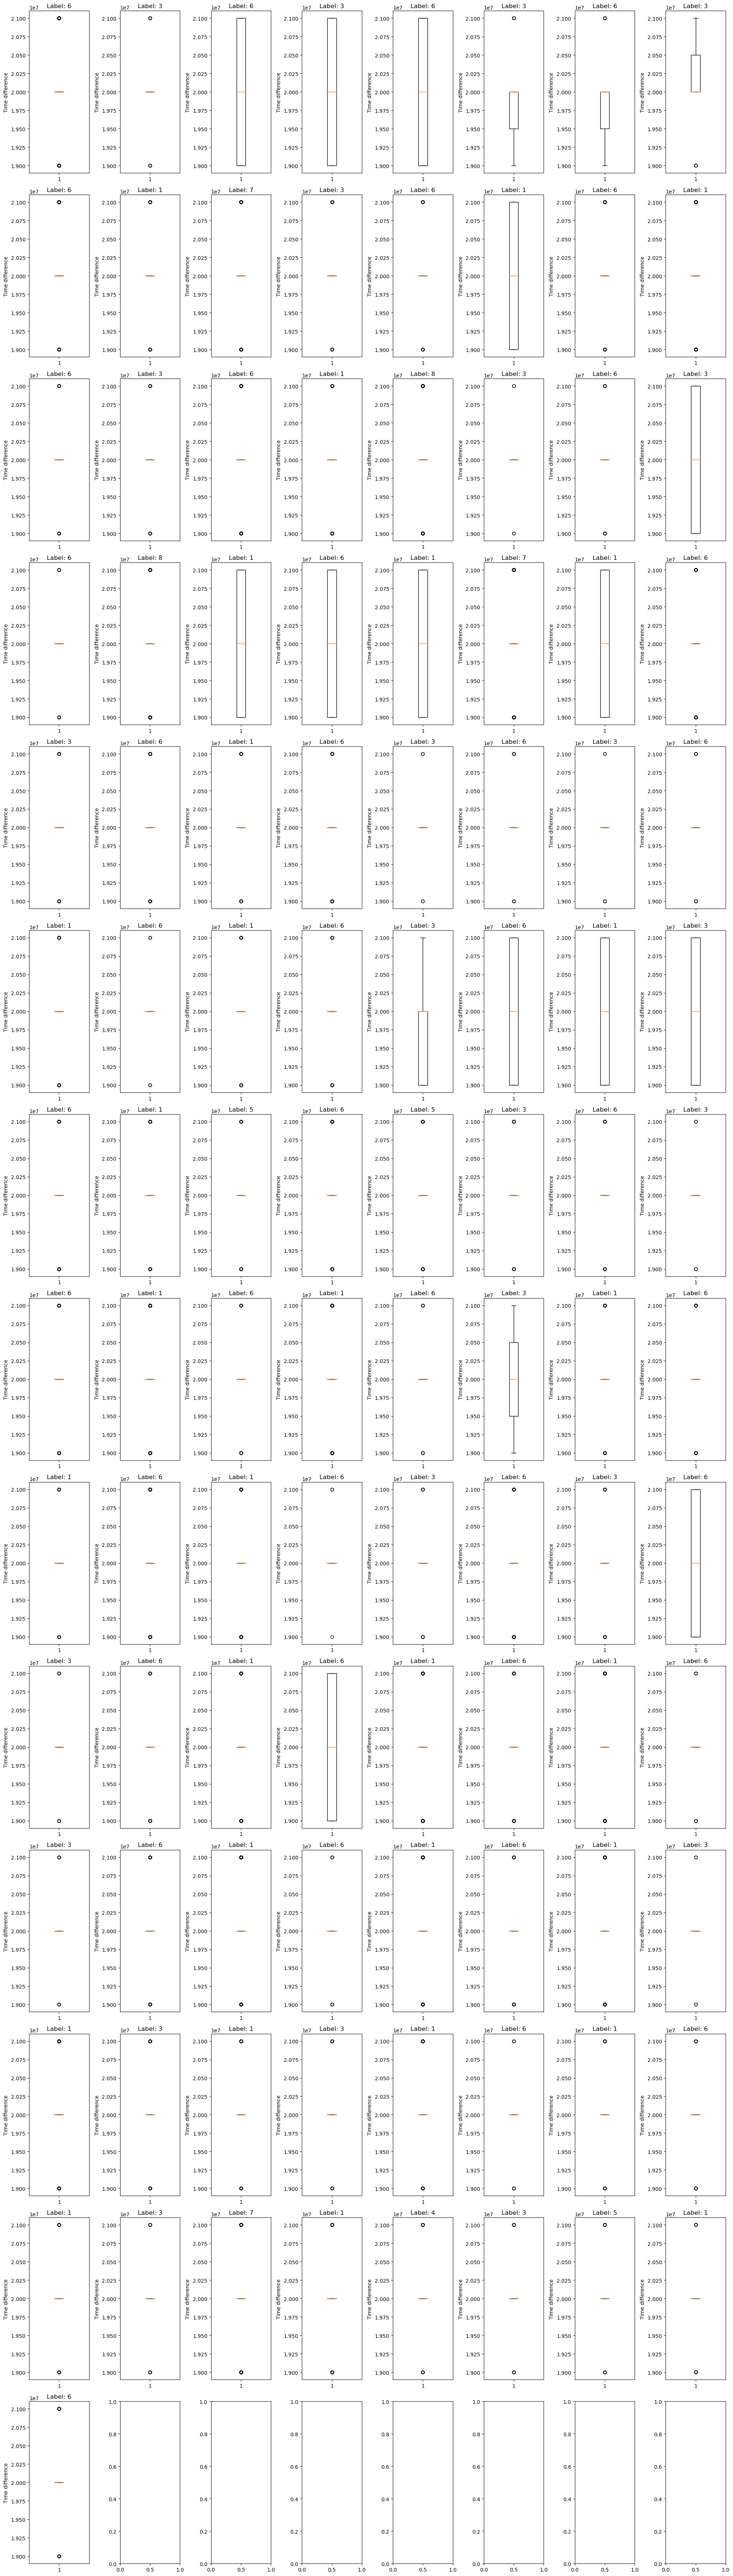

In [53]:
#The time differences within each label are more consistent, but there is still a range of values, which suggests that the timestamps are not evenly spaced
# Let's plot a boxplot of the time differences for each split

num_per_row = 8
n_rows = n_plots // num_per_row + n_plots % num_per_row

fig, axs = plt.subplots(n_rows, num_per_row, figsize=(20, 5 * n_rows))

for i, split in enumerate(label_change_splits):
    split = split.copy()
    split['timestamp'] = pd.to_datetime(split['timestamp'])
    split_time_diff = split['timestamp'].diff()
    
    # Only plot the time differences, ignore the first NaN
    split_time_diff = split_time_diff.iloc[1:]
    
    ax = axs[i // num_per_row, i % num_per_row]
    ax.boxplot(split_time_diff)
    ax.set_title(f"Label: {split['label'].iloc[0]}")
    ax.set_ylabel('Time difference')
    
plt.tight_layout()
plt.show()
    

For most of the box plots, the range of time differences is small, but there are occasional outliers

This likely indicates a roughly consistent sampling rate, but with occasional delays or missed samples

This should mean that the data can be mostly treated as a time series, but with some caution, and some augmentation of the models may be necessary to handle the continuous nature of the data. This may lend itself nicely to the ESNs, along with augmentation such as attention mechanisms, or differential equations.